# Introduction to Analysis & Machine Learning: Bees vs. Wasps!



## A Few Important Python Libraries and Tools:
Numpy: Allows for the manipulation of multi-dimensional arrays & matrices  alongside advanced mathematical functions (beginner's guide: https://numpy.org/doc/stable/user/absolute_beginners.html)

Pandas: Used for data manipulation and analysis (intro to pandas: https://pandas.pydata.org/docs/user_guide/10min.html)

Matplotlib: Widely used data visualization library (examples: https://matplotlib.org/stable/gallery/index.html)

Scikit-learn: A popular machine learning library featuring various ML algorithms, works well with NumPy (scikit-learn's homepage - highly recommend visiting: https://scikit-learn.org/stable/)

Google Colab + Jupyter Notebooks: Software used to easily share code with tools for documentation




In [28]:
##imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from skimage import io
from skimage.transform import resize
from google.colab import drive

## Analyzing and Selecting Features

Before getting started, it's important to identify all features of the dataset(s) you're working with. Depending on where you get your dataset from, there is usually a summary of the features provided (metadata). You can access the dataset we're using today and information about it here: https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp.
<br><br>
Another way to understand features of a dataset is by simply viewing the data. We'll use Pandas to load our CSV file into a dataframe, which will allow us to see and work with the data directly.

In [29]:
#loading data and creating dataframe
drive.mount('/content/drive')
file = '/content/drive/MyDrive/Analysis Workshops/labels.csv'
data = pd.read_csv(file)

#showing the first 5 lines of our file
print(data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
          id                                        path  is_bee  is_wasp  \
0          1           bee1\10007154554_026417cfd0_n.jpg       1        0   
1          2           bee1\10024864894_6dc54d4b34_n.jpg       1        0   
2          3           bee1\10092043833_7306dfd1f0_n.jpg       1        0   
3          4            bee1\1011948979_fc3637e779_w.jpg       1        0   
4          5           bee1\10128235063_dca17db76c_n.jpg       1        0   
...      ...                                         ...     ...      ...   
11416  11417                   other_noinsect\581704.jpg       0        0   
11417  11418                   other_noinsect\581873.jpg       0        0   
11418  11419                   other_noinsect\581880.jpg       0        0   
11419  11420  other_noinsect\6778651038_294d392627_n.jpg       0        0   
11420  11421  other_noin

Some important features to note include id (row number), is_bee, is_wasp, is_otherinsect, is_other (not an insect), and photo_quality. Depending on what we want our model to accomplish, some of these features may be more important than others, and some may be completely irrelevant.

Since we only want our model to determine whether an image is of a wasp or a bee, it's obvious that features like is_otherinsect won't be relevant. However, feature selection isn't always this obvious. A more exact method is to use statistical feature selection methods, which will evaluate the relationship betweeen features and the target output. Alternatively, you can view research papers related to your project to see what features others determined to be important.

Visualizing your data prior to starting your project can also be helpful. In our case, we can look at the number of bees and wasps in our dataset, and also take a look at some of the images.

4943
3183


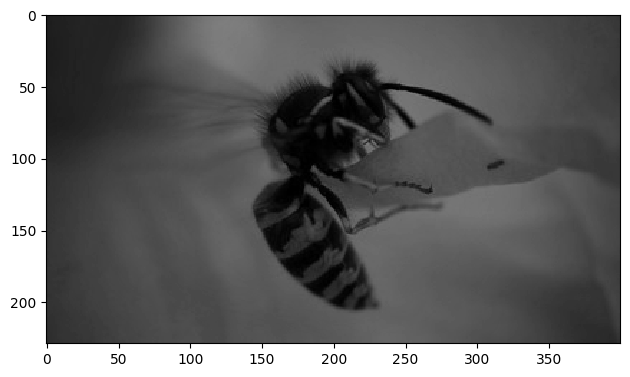

In [30]:
#number of bees and wasps
wasps = (data['label'] == 'wasp')
bees = (data['label'] == 'bee')

print(wasps.sum())
print(bees.sum())

#showing an actual image

#we have to modify the path name since the dataset to properly access othe images within our Google Drive
path = '/content/drive/MyDrive/Analysis Workshops/' + data['path'][4640].replace("\\", "/")
image = io.imread(path, as_gray = True)
io.imshow(image)

##Selecting a Model

Usually, a few types of models could be applicable to a project. The possible models are determined by what you want your project to accomplish, what features/data you have access to, and what has historically worked for similar projects/research areas. For our workshop, we want our model to classify images as bees or wasps, meaning that we need a classification model. We also want to use a supervised model, since we are giving the model input data to predict something. Some options satisfying these criteria include K-Nearest Neighbors models, Support Vector Machines, Multi-Layer Perceptron, Decision Trees, and Logistic Regression. From looking at similar projects, MLP seems to be a viable model option, while some of the other options such as Logistic Regression won't provide the outputs we are looking for.

##Data Preprocessing

The idea of data preprocessing is that we want to transform our existing data into something that can be easily and efficiently used by our model to generate an output. Unfortunately, it can get messy, and preprocessing needs will vary for every dataset or model. Generally, some common steps of preprocessing include removing unnecessary features, sampling, and data manipulation.

We'll start with removing any features that won't be helpful to our model. Using the Pandas drop method makes this easy:

In [31]:
#REMOVING UNWANTED FEATURES

#since we only care about bees and wasps, remove any rows from our sample that are not bees or wasps (aka is_otherinsect or is_other = 1)
#we also don't want poor quality images (photo_quality = 0)

others = data[(data['is_otherinsect']==1) | (data['is_other']==1) | (data['photo_quality']==0)].index #obtaining rows that are not bees or wasps or bad quality
data.drop(others, inplace=True)

Next, we'll sample our dataset, since we currently have over 7000 images to work with. A random sample is ideal, since the dataset is organized by insect type.

In [32]:
#SAMPLING

#take a random sample of 100 images from our dataset
data = data.sample(n=50)

print(data.head())

        id                               path  is_bee  is_wasp  \
3493  3494   wasp1\173580414_8f06041222_n.jpg       0        1   
1276  1277   bee1\3881126310_c469bbd70a_n.jpg       1        0   
4615  4616  wasp1\4864529655_8e02cba1a4_n.jpg       0        1   
1687  1688    bee1\530437513_3effe74ac7_n.jpg       1        0   
8        9  bee1\10197482094_0176d1bacb_n.jpg       1        0   

      is_otherinsect  is_other  photo_quality  is_validation  \
3493               0         0              1              0   
1276               0         0              1              1   
4615               0         0              1              0   
1687               0         0              1              0   
8                  0         0              1              0   

      is_final_validation label  
3493                    0  wasp  
1276                    0   bee  
4615                    1  wasp  
1687                    0   bee  
8                       0   bee  


Modifying the data is usually the most complicated part. The most important thing to understand is that we are transforming the image paths into grayscale value arrays in dimensions that can be processed by our SVM classifier. We encourage everyone to read through this section, but don't fixate too much on it.

/content/drive/MyDrive/Analysis Workshops/wasp1/173580414_8f06041222_n.jpg


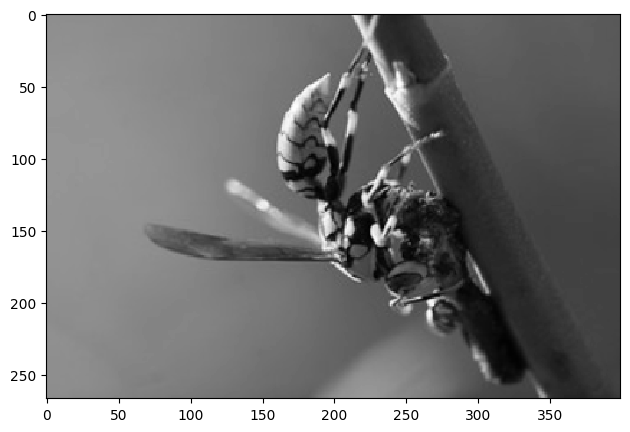

In [33]:
#MODIFYING DATA

#modifying path column to allow access to images from google drive
for i in data['path']:
  path = '/content/drive/MyDrive/Analysis Workshops/' + i.replace("\\", "/")
  data['path'] = data['path'].replace(i, path)


#right now, our dataset only contains image paths, not actual images.
#we will need to first access the actual images, convert them to grayscale arrays, resize the arrays to a uniform size, and then flatten the arrays.
#after modifying the images into a form that can be processed by our classifier, we will be able to actually create and train the model.


#finding the max width and height of the images in our dataset - this will help us find what dimensions we need to resize all the images to
max_w = 0
max_h = 0

labels = []
paths = []

for path, label in zip(data['path'], data['label']):
  try: #sometimes the image paths from the dataset aren't actually in the image folder
    image = io.imread(path, as_gray=True)
    labels.append(label)
    paths.append(path)
  except:
    print("dropped an image due to file not existing.")
    continue
  if image.shape[0] > max_h:
    max_h = image.shape[0]
  if image.shape[1] > max_w:
    max_w = image.shape[1]


#transforming images into flattened grayscale arrays
#we chose to transform the images to grayscale because this cuts down on input size. with RGB images, the input size is tripled
#this can lead to significantly longer runtimes

#creating an empty ndarray with each element of size max_w * max_h. this will eventually hold all of our modified image arrays
grayscale = np.empty((0, max_h*max_w))


for path in paths:
  image = io.imread(path, as_gray=True)#converts image to grayscale

  #we have to resize the image arrays to the same size so that they can be properly appended to the grayscale array - errors will occur otherwise
  image = resize(image, (max_h, max_w))

  #we also need to flatten the image arrays so that they can be processed by the classifier
  image = image.flatten()

  #adding the flattened array to our grayscale array
  grayscale = np.append(grayscale, [image], axis=0)


print(paths[0])
image = grayscale[0].reshape(max_h, max_w)
io.imshow(image)


##Building and Training the SVM Model

Now that our data is preprocessed, we can move ahead to using sklearn to create, fit, and test our model.

Since this is a classifier, we need to split our data into the observed images and the corresponding classification.

In [34]:
#define the observed data (images) and what we are trying to predict (the label)

X, y = grayscale, labels

And, since we are working with a supervised model, we want to split our data into a training set (which we will use to train the model on) and a testing set (which will test the model's accuracy).

In [35]:
#we will split our X and y (one to be used as a training set, the other for testing) - does not need to be equally split

X_train, X_test, y_train, y_test, path_train, path_test = train_test_split(
    X, y, paths, test_size=0.2, shuffle=True
)

#examining the composition of our training and testing sets
wasp_train = y_train.count('wasp')
bee_train = y_train.count('bee')
wasp_test = y_test.count('wasp')
bee_test = y_test.count('bee')

print(wasp_train)
print(bee_train)
print(wasp_test)
print(bee_test)

19
21
4
6


Now, we're ready to create the MLP classifier, train it, and test it:

In [36]:
#creating the model
#clf = svm.SVC(gamma=0.001)
clf = MLPClassifier(hidden_layer_sizes=(256,128,128), solver='sgd', max_iter=200)

#cross validation score
#scores = cross_val_score(clf, X, y, cv=25, scoring='f1_macro')
#print(scores.mean())
#print(scores.std())

#fit model on training set
clf.fit(X_train, y_train)

#predict the labels (bee or wasp) of the images in the testing set
predicted = clf.predict(X_test)

#compute CV score, fix sampling to equal representation of bee and wasps, cv parameter should be large (>100)

##Analyzing Outcomes

Here's the most important part: understanding how effective our model really is. Metrics like precision, recall, and f1-scores can inform us of the model's performance and strengths.

Classification report for classifier MLPClassifier(hidden_layer_sizes=(256, 128, 128), solver='sgd'):
              precision    recall  f1-score   support

         bee       0.80      0.67      0.73         6
        wasp       0.60      0.75      0.67         4

    accuracy                           0.70        10
   macro avg       0.70      0.71      0.70        10
weighted avg       0.72      0.70      0.70        10


/content/drive/MyDrive/Analysis Workshops/bee1/7611576922_306f51110b_n.jpg
/content/drive/MyDrive/Analysis Workshops/bee1/9679170523_ea3750e1a1_w.jpg
/content/drive/MyDrive/Analysis Workshops/wasp1/4864529655_8e02cba1a4_n.jpg
/content/drive/MyDrive/Analysis Workshops/bee1/6001117024_5ec0139091_n.jpg


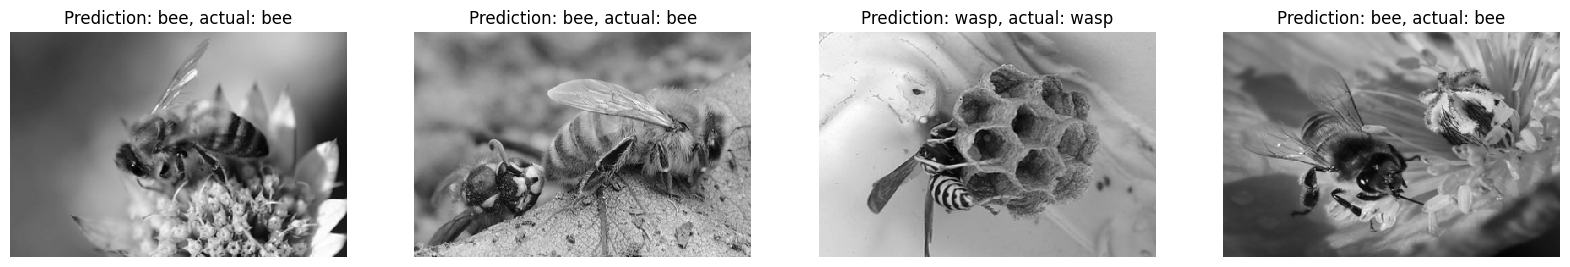

In [37]:
#classification report
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

#showing images, predicted vs actual
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
for ax, image, actual, prediction, file in zip(axes, X_test, y_test, predicted, path_test):
    ax.set_axis_off()
    print(file)
    image = image.reshape(max_h, max_w)
    ax.imshow(image, cmap='binary_r', interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}, actual: {actual}")

###Why doesn't the model have an accuracy score of 0.99?!?!
There's a few possible reasons for this:
- the model we used wasn't the best option
- we need more specified feature selection/better data
- hyperparameters weren't tuned

The most likely cause is that the size of the bees/wasps in relation to the image size is inconsistent, so size/shape (which is a key determining factor) can be hard for the MLP to decipher. Another issue is the surrounding plants, which can also trip up the model (for example, if the image has a flower, the model may classify the image as a bee). Other features that would help our model to perform better would include color, wing-to-appendix ratios, etc. Ultimately, the images in our dataset are tough to work with. As an alternative to more preprocessing, we can try to fine-tune hyperparameters using GridSearchCV to determine the best parameters to use.

Hyperparameter tuning:

In [38]:
##Note: running this will take a while, especially if you add more hyperparameters to test.

#parameter_space = {
    #'hidden_layer_sizes': [(128,64,32),(50,50,50)],
    #'solver': ['sgd', 'adam'],
    #'max_iter': [200,500]
#}

#clf = GridSearchCV(MLPClassifier(), parameter_space, n_jobs=-1, cv=3)
#clf.fit(X_train, y_train)
# Best parameter set
#print('Best parameters found:\n', clf.best_params_)